In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain-community langchain-anthropic tavily-python pandas  langchain_groq langchain_fireworks

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Self_Discover_Agent"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC_API_KEY")
os.environ["SCRAPYBARA_API_KEY"] = userdata.get("SCRAPYBARA_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["FIREWORKS_API_KEY"] = userdata.get("FIREWORKS_API_KEY")
from langchain import hub
from langchain_groq import ChatGroq
from langchain.agents import create_openai_functions_agent

llm = ChatGroq(model_name = "llama3-70b-8192",api_key = os.environ["GROQ_API_KEY"])



In [ ]:
from langchain_fireworks import ChatFireworks
llm1 = ChatFireworks(model="account/fireworks/models/mixtral-8x7b-instruct",max_tokens=32768)

In [ ]:
from langchain import hub

select_prompt = hub.pull("hwchase17/self-discovery-select")
print("Self-Discovery Select Prompt:")

select_prompt.pretty_print()

Self-Discovery Select Prompt:
Select several reasoning modules that are crucial to utilize in order to solve the given task:

All reasoning module descriptions:
{reasoning_modules}

Task: {task_description}

Select several modules are crucial for solving the task above:



In [ ]:
adapt_prompt = hub.pull("hwchase17/self-discovery-adapt")
print("Self-Discovery Adapt Prompt:")
adapt_prompt.pretty_print()

Self-Discovery Adapt Prompt:
Rephrase and specify each reasoning module so that it better helps solving the task:

SELECTED module descriptions:
{selected_modules}

Task: {task_description}

Adapt each reasoning module description to better solve the task:



In [ ]:
structured_prompt = hub.pull("hwchase17/self-discovery-structure")
print("Self-Discovery Structured Prompt:")
structured_prompt.pretty_print()

Self-Discovery Structured Prompt:
Operationalize the reasoning modules into a step-by-step reasoning plan in JSON format:

Here's an example:

Example task:

If you follow these instructions, do you return to the starting point? Always face forward. Take 1 step backward. Take 9 steps left. Take 2 steps backward. Take 6 steps forward. Take 4 steps forward. Take 4 steps backward. Take 3 steps right.

Example reasoning structure:

{
    "Position after instruction 1":
    "Position after instruction 2":
    "Position after instruction n":
    "Is final position the same as starting position":
}

Adapted module description:
{adapted_modules}

Task: {task_description}

Implement a reasoning structure for solvers to follow step-by-step and arrive at correct answer.

Note: do NOT actually arrive at a conclusion in this pass. Your job is to generate a PLAN so that in the future you can fill it out and arrive at the correct conclusion for tasks like this


In [ ]:
from langchain import hub

select_prompt = hub.pull("hwchase17/self-discovery-select")
print("Self-Discovery Select Prompt:")
select_prompt.pretty_print()
print("Self-Discovery Select Response:")
adapt_prompt = hub.pull("hwchase17/self-discovery-adapt")
adapt_prompt.pretty_print()
structured_prompt = hub.pull("hwchase17/self-discovery-structure")
print("Self-Discovery Structured Prompt:")
structured_prompt.pretty_print()
reasoning_prompt = hub.pull("hwchase17/self-discovery-reasoning")
print("Self-Discovery Structured Response:")
reasoning_prompt.pretty_print()

Self-Discovery Select Prompt:
Select several reasoning modules that are crucial to utilize in order to solve the given task:

All reasoning module descriptions:
{reasoning_modules}

Task: {task_description}

Select several modules are crucial for solving the task above:

Self-Discovery Select Response:
Rephrase and specify each reasoning module so that it better helps solving the task:

SELECTED module descriptions:
{selected_modules}

Task: {task_description}

Adapt each reasoning module description to better solve the task:

Self-Discovery Structured Prompt:
Operationalize the reasoning modules into a step-by-step reasoning plan in JSON format:

Here's an example:

Example task:

If you follow these instructions, do you return to the starting point? Always face forward. Take 1 step backward. Take 9 steps left. Take 2 steps backward. Take 6 steps forward. Take 4 steps forward. Take 4 steps backward. Take 3 steps right.

Example reasoning structure:

{
    "Position after instruction 1

In [ ]:
reasoning_prompt = hub.pull("hwchase17/self-discovery-reasoning")
print("Self-Discovery Reasoning Prompt:")
adapt_prompt.pretty_print()

Self-Discovery Reasoning Prompt:
Operationalize the reasoning modules into a step-by-step reasoning plan in JSON format:

Here's an example:

Example task:

If you follow these instructions, do you return to the starting point? Always face forward. Take 1 step backward. Take 9 steps left. Take 2 steps backward. Take 6 steps forward. Take 4 steps forward. Take 4 steps backward. Take 3 steps right.

Example reasoning structure:

{
    "Position after instruction 1":
    "Position after instruction 2":
    "Position after instruction n":
    "Is final position the same as starting position":
}

Adapted module description:
{adapted_modules}

Task: {task_description}

Implement a reasoning structure for solvers to follow step-by-step and arrive at correct answer.

Note: do NOT actually arrive at a conclusion in this pass. Your job is to generate a PLAN so that in the future you can fill it out and arrive at the correct conclusion for tasks like this


In [ ]:
from typing import Optional
from typing_extensions import TypedDict
from langgraph.graph import START,END,StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
output_parsers = StrOutputParser()

class SelfDiscoveryState(TypedDict):
  reasoning_modules : str
  task_description : str
  selected_modules : Optional[str]
  adapted_modules :Optional[str]
  reasoning_structure : Optional[str]
  answer: Optional[str]

model = llm


def select(inputs):
  select_chain = select_prompt | model | output_parsers
  return {"selected_modules":select_chain.invoke(inputs)}


def adapt(inputs):
  adapt_chain = adapt_prompt | model | output_parsers
  return {"adapted_modules":adapt_chain.invoke(inputs)}



def structure(inputs):
  structure_chain = structured_prompt | model | output_parsers
  return {"reasoning_structure":structure_chain.invoke(inputs)}


def reasoning(inputs):
  reasoning_chain = reasoning_prompt | model | output_parsers
  return {"answer":reasoning_chain.invoke(inputs)}



graph = StateGraph(SelfDiscoveryState)

graph.add_node(select)

graph.add_node(adapt)

graph.add_node(structure)

graph.add_node(reasoning)


graph.add_edge(START,"select")


graph.add_edge("select","adapt")

graph.add_edge("adapt","structure")

graph.add_edge("structure","reasoning")

graph.add_edge("reasoning",END)


app = graph.compile()

In [ ]:
! pip install IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00


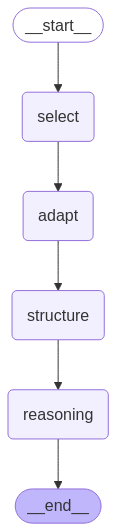

In [ ]:
from IPython.display import Image,display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
reasoning_modules = [
    "1. How could I devise an experiment to help solve that problem?",
    "2. Make a list of ideas for solving this problem, and apply them one by one to the problem to see if any progress can be made.",
    # "3. How could I measure progress on this problem?",
    "4. How can I simplify the problem so that it is easier to solve?",
    "5. What are the key assumptions underlying this problem?",
    "6. What are the potential risks and drawbacks of each solution?",
    "7. What are the alternative perspectives or viewpoints on this problem?",
    "8. What are the long-term implications of this problem and its solutions?",
    "9. How can I break down this problem into smaller, more manageable parts?",
    "10. Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available. It focuses on logical reasoning, evidence-based decision-making, and identifying potential biases or flaws in thinking.",
    "11. Try creative thinking, generate innovative and out-of-the-box ideas to solve the problem. Explore unconventional solutions, thinking beyond traditional boundaries, and encouraging imagination and originality.",
    # "12. Seek input and collaboration from others to solve the problem. Emphasize teamwork, open communication, and leveraging the diverse perspectives and expertise of a group to come up with effective solutions.",
    "13. Use systems thinking: Consider the problem as part of a larger system and understanding the interconnectedness of various elements. Focuses on identifying the underlying causes, feedback loops, and interdependencies that influence the problem, and developing holistic solutions that address the system as a whole.",
    "14. Use Risk Analysis: Evaluate potential risks, uncertainties, and tradeoffs associated with different solutions or approaches to a problem. Emphasize assessing the potential consequences and likelihood of success or failure, and making informed decisions based on a balanced analysis of risks and benefits.",
    # "15. Use Reflective Thinking: Step back from the problem, take the time for introspection and self-reflection. Examine personal biases, assumptions, and mental models that may influence problem-solving, and being open to learning from past experiences to improve future approaches.",
    "16. What is the core issue or problem that needs to be addressed?",
    "17. What are the underlying causes or factors contributing to the problem?",
    "18. Are there any potential solutions or strategies that have been tried before? If yes, what were the outcomes and lessons learned?",
    "19. What are the potential obstacles or challenges that might arise in solving this problem?",
    "20. Are there any relevant data or information that can provide insights into the problem? If yes, what data sources are available, and how can they be analyzed?",
    "21. Are there any stakeholders or individuals who are directly affected by the problem? What are their perspectives and needs?",
    "22. What resources (financial, human, technological, etc.) are needed to tackle the problem effectively?",
    "23. How can progress or success in solving the problem be measured or evaluated?",
    "24. What indicators or metrics can be used?",
    "25. Is the problem a technical or practical one that requires a specific expertise or skill set? Or is it more of a conceptual or theoretical problem?",
    "26. Does the problem involve a physical constraint, such as limited resources, infrastructure, or space?",
    "27. Is the problem related to human behavior, such as a social, cultural, or psychological issue?",
    "28. Does the problem involve decision-making or planning, where choices need to be made under uncertainty or with competing objectives?",
    "29. Is the problem an analytical one that requires data analysis, modeling, or optimization techniques?",
    "30. Is the problem a design challenge that requires creative solutions and innovation?",
    "31. Does the problem require addressing systemic or structural issues rather than just individual instances?",
    "32. Is the problem time-sensitive or urgent, requiring immediate attention and action?",
    "33. What kinds of solution typically are produced for this kind of problem specification?",
    "34. Given the problem specification and the current best solution, have a guess about other possible solutions."
    "35. Let’s imagine the current best solution is totally wrong, what other ways are there to think about the problem specification?"
    "36. What is the best way to modify this current best solution, given what you know about these kinds of problem specification?"
    "37. Ignoring the current best solution, create an entirely new solution to the problem."
    # "38. Let’s think step by step."
    "39. Let’s make a step by step plan and implement it with good notation and explanation.",
]



In [ ]:
task_example = "Lisa has 10 apples. She gives 3 apples to her friend and then buys 5 more apples from the store. How many apples does Lisa have now?"

task_example = """This SVG path element <path d="M 55.57,80.69 L 57.38,65.80 M 57.38,65.80 L 48.90,57.46 M 48.90,57.46 L
45.58,47.78 M 45.58,47.78 L 53.25,36.07 L 66.29,48.90 L 78.69,61.09 L 55.57,80.69"/> draws a:
(A) circle (B) heptagon (C) hexagon (D) kite (E) line (F) octagon (G) pentagon(H) rectangle (I) sector (J) triangle"""

reasoning_modules_str = "\n".join(reasoning_modules)

for s in app.stream(
    {"task_description": task_example, "reasoning_modules": reasoning_modules_str}
):
    print(s)

{'select': {'selected_modules': 'Based on the task, I would select the following reasoning modules as crucial for solving the task:\n\n1. **What is the core issue or problem that needs to be addressed?** (Module 16): This module helps to clarify the problem and understand what needs to be solved.\n\n2. **How can I break down this problem into smaller, more manageable parts?** (Module 9): Breaking down the problem into smaller parts, such as analyzing the SVG path element, can help to identify the shape being drawn.\n\n3. **What are the relevant data or information that can provide insights into the problem?** (Module 20): In this case, the relevant data is the SVG path element, which provides the coordinates and instructions for drawing the shape.\n\n4. **Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available.** (Module 10): Critical thinking is essential to analyze the SVG 

In [ ]:
! pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
    "I want to learn AI",
    "I am Learning about llm",
    "I Hate My College"
]

vectorizer = CountVectorizer()

x = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())

print(x.toarray())

vectorizer1 = TfidfVectorizer()

x1 = vectorizer1.fit_transform(corpus)

print(vectorizer1.get_feature_names_out())
print(x1.toarray())

['about' 'ai' 'am' 'college' 'hate' 'learn' 'learning' 'llm' 'my' 'to'
 'want']
[[0 1 0 0 0 1 0 0 0 1 1]
 [1 0 1 0 0 0 1 1 0 0 0]
 [0 0 0 1 1 0 0 0 1 0 0]]
['about' 'ai' 'am' 'college' 'hate' 'learn' 'learning' 'llm' 'my' 'to'
 'want']
[[0.         0.5        0.         0.         0.         0.5
  0.         0.         0.         0.5        0.5       ]
 [0.5        0.         0.5        0.         0.         0.
  0.5        0.5        0.         0.         0.        ]
 [0.         0.         0.         0.57735027 0.57735027 0.
  0.         0.         0.57735027 0.         0.        ]]
